<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

In [6]:
try:
    data = pd.read_csv("datasets/taxi.csv", index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

## Подготовка

Посмотрим на данные

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
data = data.dropna()

Выполним ресемплирование по часу

In [10]:
data = data.sort_index()

In [11]:
data = data.resample('1H').sum()

In [12]:
print(data.index.is_monotonic)

True


проверим в хронологическом ли порядке расположены данные

## Анализ

Text(0.5, 1.0, 'Trend')

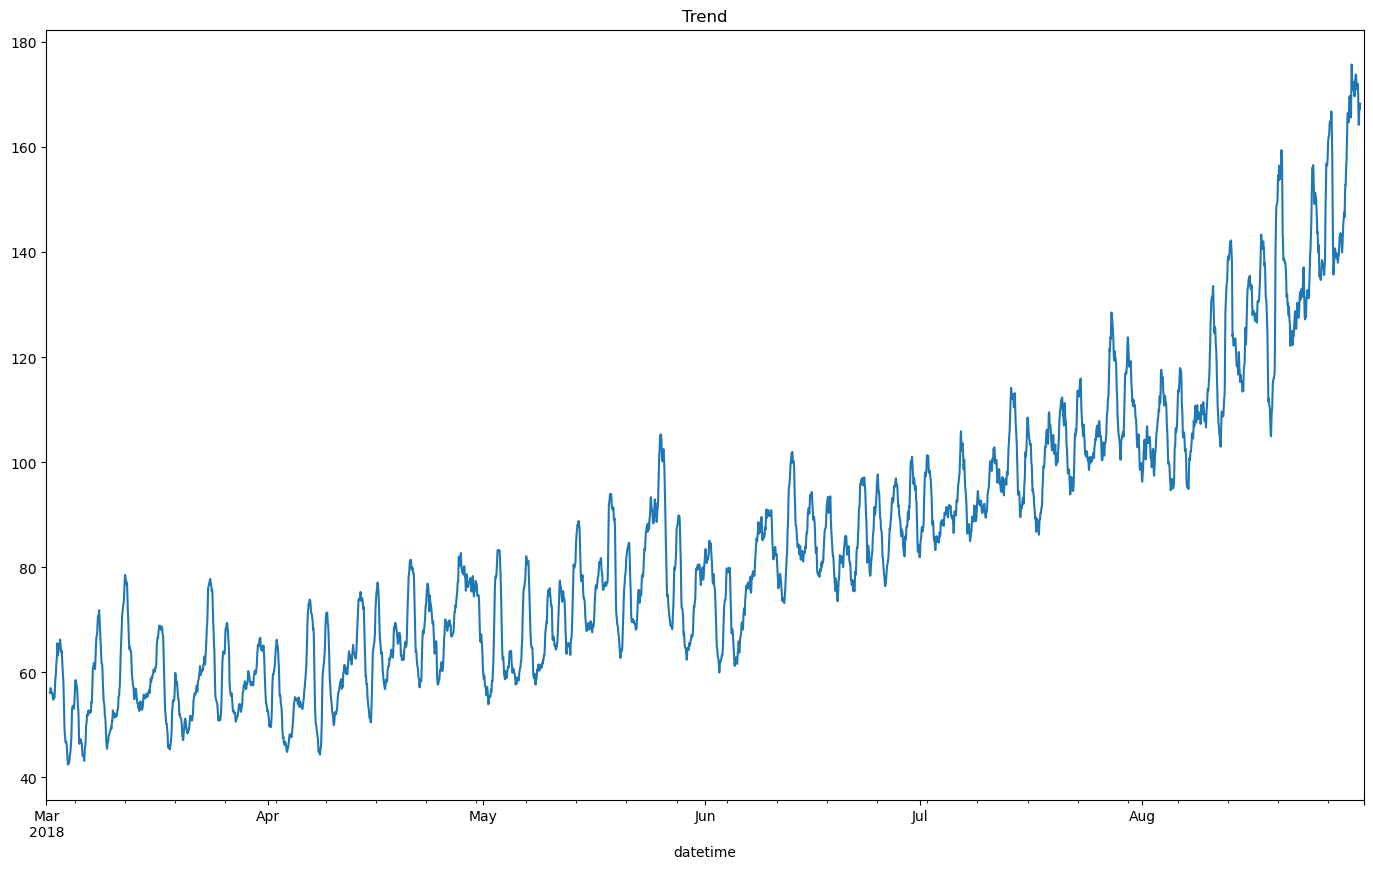

In [13]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(17, 10))
decomposed.trend.plot()
plt.title('Trend')

Посмотрим в разрезе месяца

Text(0.5, 1.0, 'Mounth')

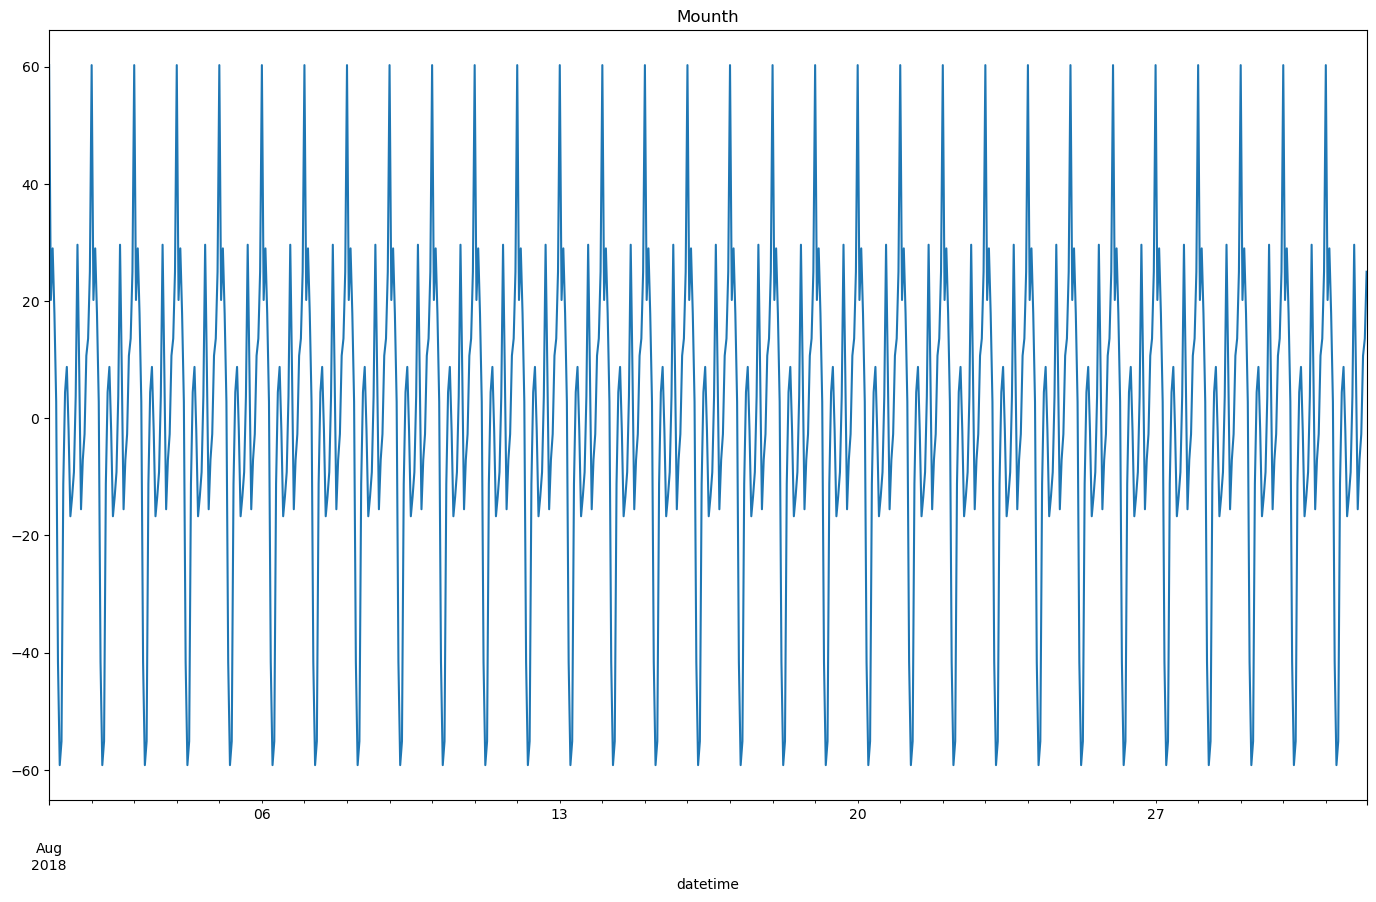

In [14]:
mounth = decomposed.seasonal['2018-08-01':'2018-08-31']
plt.figure(figsize=(17, 10))
mounth.plot()
plt.title('Mounth')

Недели

Text(0.5, 1.0, 'week')

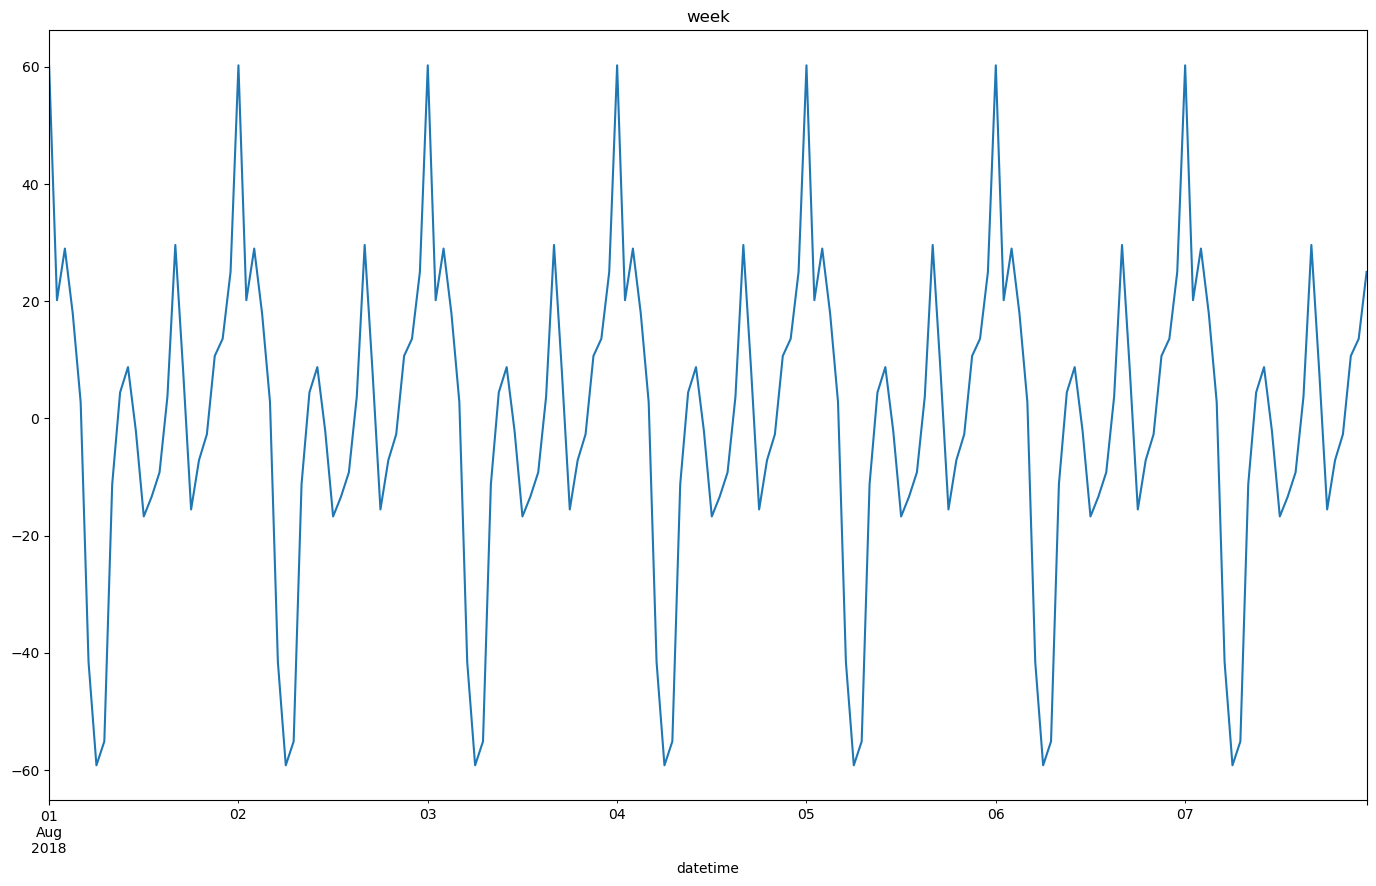

In [15]:
week = decomposed.seasonal['2018-08-01':'2018-08-07']
plt.figure(figsize=(17, 10))
week.plot()
plt.title('week')

Сутки

Text(0.5, 1.0, 'day')

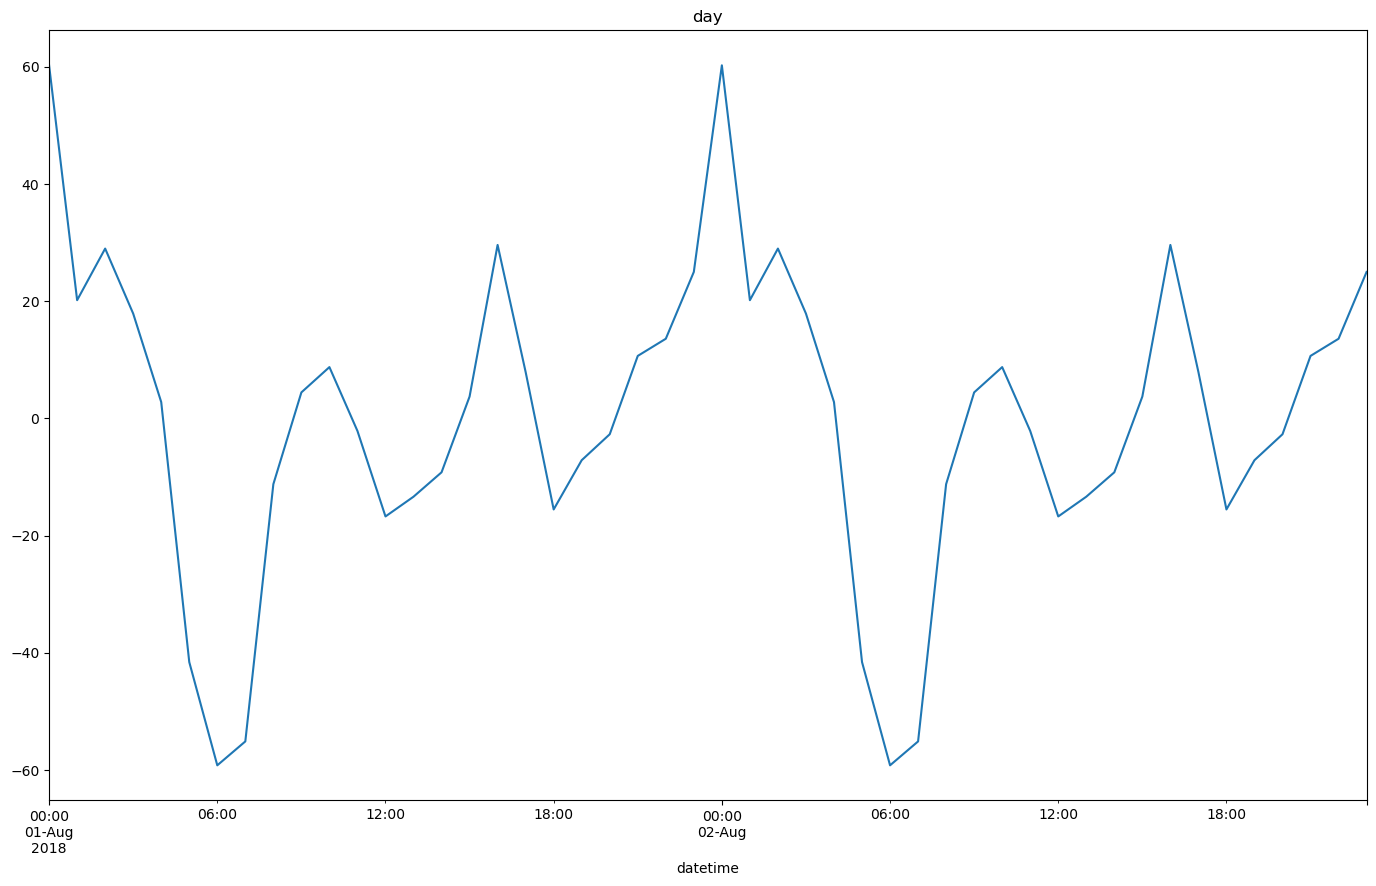

In [16]:
day = decomposed.seasonal['2018-08-01':'2018-08-02']
plt.figure(figsize=(17, 10))
day.plot()
plt.title('day')

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(
        rolling_mean_size).mean()


make_features(data, 24, 30)

In [18]:
data.dropna(inplace=True)

Данных мало, по этой причине говорить о сезоности тяжело. По графику можно понять, что заказы увеличиваются, но однозначно сказать, что от сезоности нельзя.
Также видимо на сутутчном графики активность в вечернее время.
Ускорение тренда в августе.
Сезоности за неделю нет, одинаково ...
Сезонность за сутки. Минимальное число заказов приходится на 6 утра, максимальное на 12 ночи. Также высокое число заказов в вечернее время (4-5 часов вечера).

## Обучение

Делим выборку

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()


train_target = train['num_orders']
test_target = test['num_orders']


train_features = train.drop('num_orders', axis=1)
test_features = test.drop('num_orders', axis=1)

In [20]:
tscv = TimeSeriesSplit(n_splits=10)

Линейная регрессия

In [21]:
model_lr = LinearRegression()

model_lr.fit(train_features, train_target)
train_pred = model_lr.predict(train_features)
rmse = mean_squared_error(train_target, train_pred)**0.5
test_pred = model_lr.predict(test_features)
rmse_test = mean_squared_error(test_target, test_pred)**0.5
print('Обучающая выборка:', rmse)
print('Тестовая выборка:', rmse_test)

Обучающая выборка: 25.605540563496792
Тестовая выборка: 45.39852369967062


In [22]:
scores = cross_val_score(model_lr, train_features, train_target,
                         scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)
_rmse = -1*np.mean(scores)

[CV] END .............................. score: (test=-21.106) total time=   0.0s
[CV] END .............................. score: (test=-21.334) total time=   0.0s
[CV] END .............................. score: (test=-25.072) total time=   0.0s
[CV] END .............................. score: (test=-23.293) total time=   0.0s
[CV] END .............................. score: (test=-25.609) total time=   0.0s
[CV] END .............................. score: (test=-25.289) total time=   0.0s
[CV] END .............................. score: (test=-25.473) total time=   0.0s
[CV] END .............................. score: (test=-28.387) total time=   0.0s
[CV] END .............................. score: (test=-32.078) total time=   0.0s
[CV] END .............................. score: (test=-34.611) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [23]:
_rmse

26.22522148375607

In [24]:
clf = DecisionTreeRegressor()
parametrs = {'min_samples_leaf': range(1, 50, 10),
             'max_depth': range(1, 70, 10),

             }

grid = GridSearchCV(clf, parametrs, cv=tscv,
                    scoring='neg_root_mean_squared_error')
grid.fit(train_features, train_target)
grid.best_params_

{'max_depth': 11, 'min_samples_leaf': 31}

DecisionTreeRegressor

In [25]:
model_tree = DecisionTreeRegressor(
    min_samples_leaf=41, max_depth=11, random_state=12345)
model_tree.fit(train_features, train_target)
train_pred = model_tree.predict(train_features)
rmse = mean_squared_error(train_target, train_pred)**0.5
test_pred = model_tree.predict(test_features)
rmse_test = mean_squared_error(test_target, test_pred)**0.5
print('Обучающая выборка:', rmse)
print('Тестовая выборка:', rmse_test)

Обучающая выборка: 23.232762966974175
Тестовая выборка: 51.315389156524546


RandomForestRegressor

In [26]:
clf = RandomForestRegressor()
parametrs = {'n_estimators': range(1, 50, 10),
             'max_depth': range(1, 70, 10),

             }

grid = GridSearchCV(clf, parametrs, cv=tscv,
                    scoring='neg_root_mean_squared_error')
grid.fit(train_features, train_target)
grid.best_params_

{'max_depth': 51, 'n_estimators': 41}

In [27]:
train_pred = grid.predict(train_features)
rmse_rf_train = mean_squared_error(train_target, train_pred)**0.5
test_pred = grid.predict(test_features)
rmse_rf_test = mean_squared_error(test_target, test_pred)**0.5

print('Обучающая выборка:', rmse_rf_train)
print('Тестовая выборка:', rmse_rf_test)

Обучающая выборка: 8.797626050236252
Тестовая выборка: 42.82918884628212


In [28]:
grid = {'n_estimators': [100, 200, 300], 'num_leaves': [31, 100, 200]}

In [29]:
model = lgb.LGBMRegressor(random_state=12345)

lgb_model = GridSearchCV(estimator=model,
                         param_grid=grid,
                         scoring='neg_root_mean_squared_error',
                         cv=tscv,
                         verbose=3)

lgb_model.fit(train_features, train_target)
display(lgb_model.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END n_estimators=100, num_leaves=31;, score=-20.124 total time=   0.1s
[CV 2/10] END n_estimators=100, num_leaves=31;, score=-19.782 total time=   0.3s
[CV 3/10] END n_estimators=100, num_leaves=31;, score=-23.778 total time=   0.2s
[CV 4/10] END n_estimators=100, num_leaves=31;, score=-22.146 total time=   0.3s
[CV 5/10] END n_estimators=100, num_leaves=31;, score=-23.994 total time=   0.3s
[CV 6/10] END n_estimators=100, num_leaves=31;, score=-21.879 total time=   0.5s
[CV 7/10] END n_estimators=100, num_leaves=31;, score=-24.638 total time=   0.4s
[CV 8/10] END n_estimators=100, num_leaves=31;, score=-24.169 total time=   0.3s
[CV 9/10] END n_estimators=100, num_leaves=31;, score=-28.702 total time=   0.3s
[CV 10/10] END n_estimators=100, num_leaves=31;, score=-31.366 total time=   0.2s
[CV 1/10] END n_estimators=100, num_leaves=100;, score=-20.124 total time=   0.1s
[CV 2/10] END n_estimators=100, num_leaves=100

{'n_estimators': 100, 'num_leaves': 31}

In [30]:
model = lgb.LGBMRegressor(random_state=12345, n_estimators=100, num_leaves=31)
model.fit(train_features, train_target)

predictions_train = model.predict(train_features)
rmse_train = mean_squared_error(train_target, predictions_train)**0.5

predictions_test = model.predict(test_features)
rmse_test = mean_squared_error(test_target, predictions_test)**0.5
print('Обучающая выборка:', rmse_train)
print('Тестовая выборка:', rmse_test)

Обучающая выборка: 12.312909021727718
Тестовая выборка: 40.29826484172045


прошли порог.

Итого Лучшая модель из перебранных нам яв-ся LGBMRegressor

## Тестирование

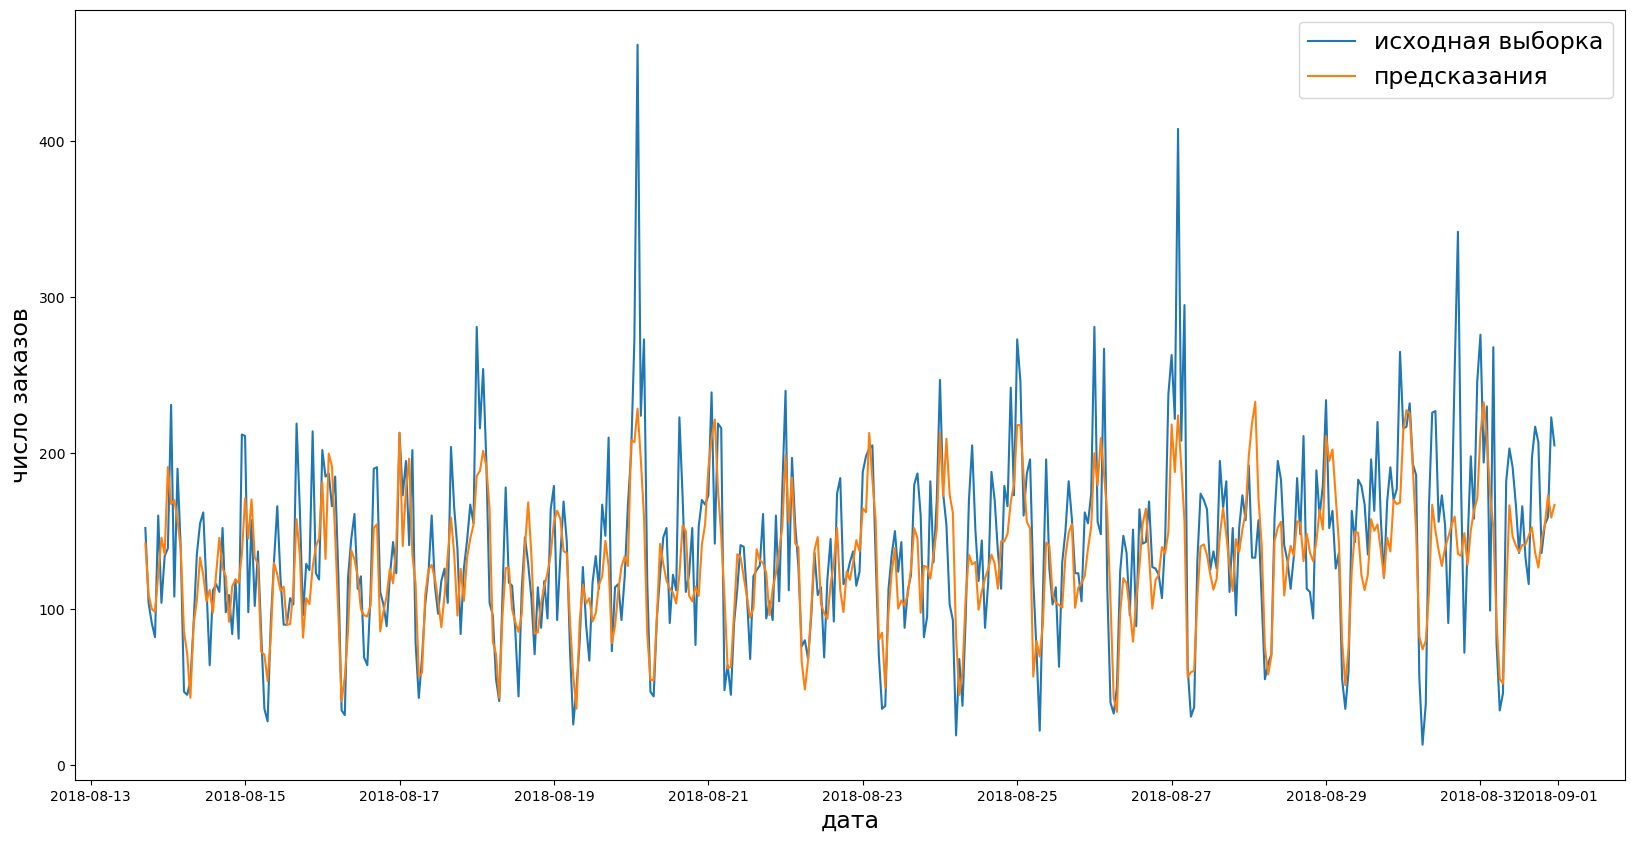

In [31]:
predictions_test = pd.Series(predictions_test, index=test_target.index)
plt.figure(figsize=(20, 10))
plt.xlabel('дата', fontsize=17)
plt.ylabel('число заказов', fontsize=17)
plt.plot(test_target, label='исходная выборка')
plt.plot(predictions_test, label='предсказания')
plt.legend(fontsize=17)
plt.show()

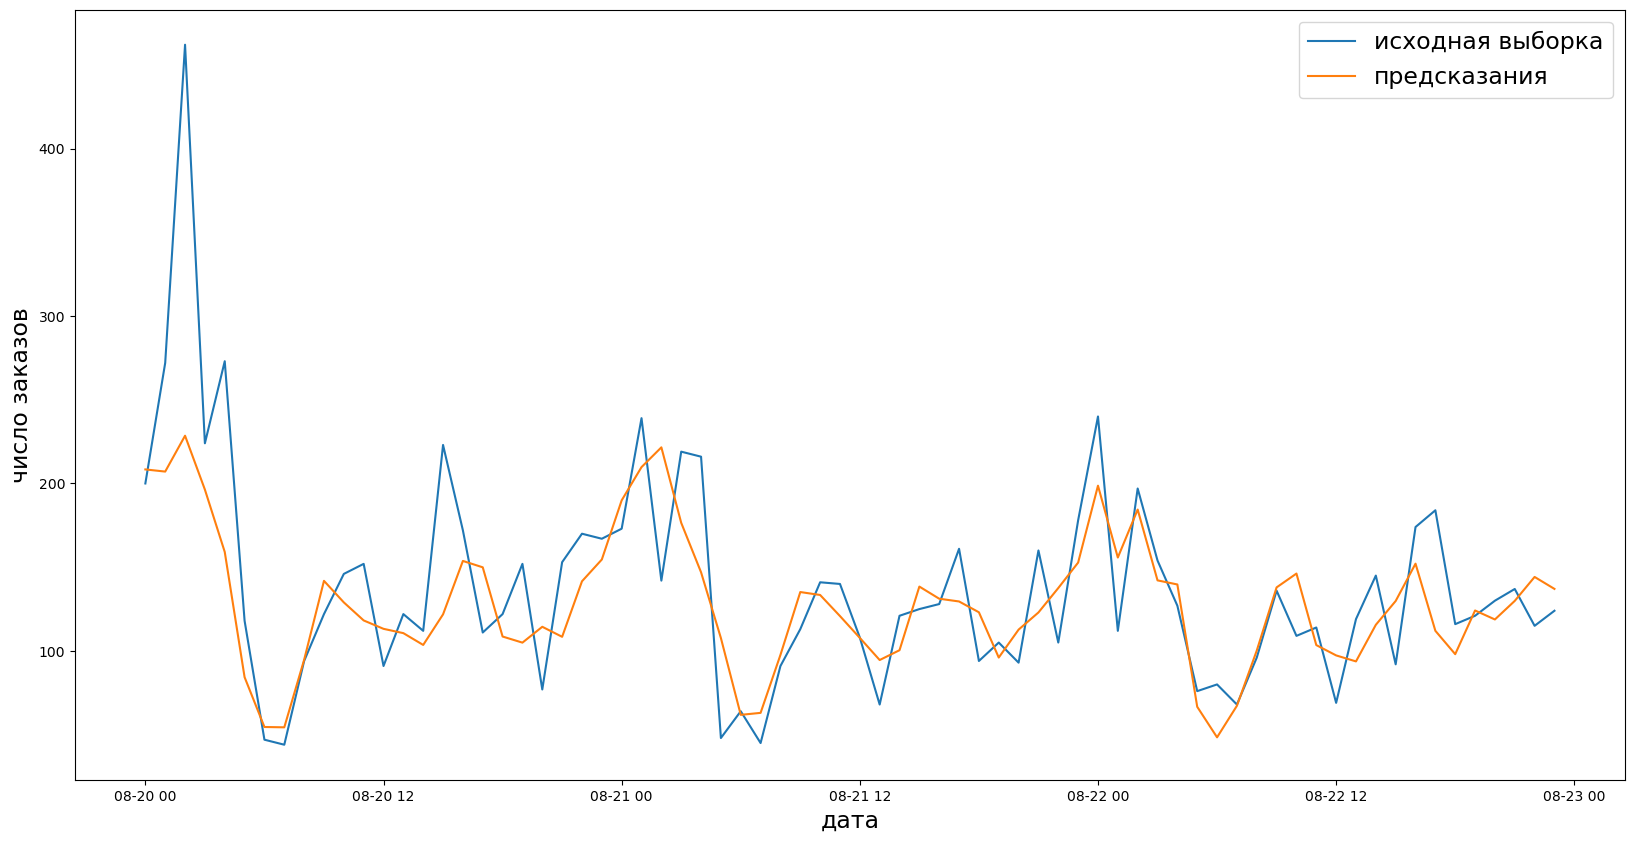

In [32]:
plt.figure(figsize=(20, 10))
plt.xlabel('дата', fontsize=17)
plt.ylabel('число заказов', fontsize=17)
plt.plot(test_target['2018-08-20':'2018-08-22'], label='исходная выборка')
plt.plot(predictions_test['2018-08-20':'2018-08-22'], label='предсказания')
plt.legend(fontsize=17)
plt.show()

In [33]:
predictions_test = model.predict(test_features)
rmse_test = mean_squared_error(test_target, predictions_test)**0.5
print('Обучающая выборка:', rmse_train)
print('Тестовая выборка:', rmse_test)

Обучающая выборка: 12.312909021727718
Тестовая выборка: 40.29826484172045


итого лучшая модель  LGBMRegressor с результатом на тестовой выборке =40.97630716868582, есть маленькие ошибки. В основном на резких пиках